In [1]:
# Notebook configurations
import sys
import dotenv
import os
import warnings

dotenv.load_dotenv()
sys.path.append(f'{os.getenv("ROOT_DIR")}')
sys.path.append(f'{os.getenv("ROOT_DIR")}\\script')

warnings.filterwarnings('ignore')

In [3]:
import umap

import hdbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import script.utils as utils
import script.dataextraction as db

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, Birch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Loading, Preprocessing and Exploration
Before moving onto the clustering, we need to load the data and preprocess it. The data is loaded from the file `/data/cached_dataset_<number>.csv` where the number is auto generated by the preprocessing pipline 

In [40]:
df = pd.read_csv(f'{os.getenv("ROOT_DIR")}\\data\\cached_dataset_1.csv')
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,mr_lods,icu_level
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,True,False,False,False,True,False,False,0.683240,Level 3
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,True,False,False,False,0.149936,Level 1
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,True,False,False,0.381497,Level 2
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,True,False,0.288948,Level 1
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,True,False,False,0.104107,Level 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,True,False,False,0.149936,Level 1
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,True,False,False,0.149936,Level 1
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,True,False,0.381497,Level 2
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,True,False,False,False,True,False,False,0.104107,Level 1


In [41]:
df.describe()

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,lods,apsiii,mlods,oasis,qsofa,saps,sapsii,sirs,sofa,mr_lods
count,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,...,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000
mean,36493.044835,86.942043,117.077011,59.701996,77.162442,18.809998,36.869379,97.376586,139.826205,14.201875,...,4.013146,43.359855,2.750319,32.236829,1.749730,18.635338,35.668106,2.891788,4.394388,0.194565
std,28536.485108,14.321800,14.818539,9.548154,9.716176,3.738380,0.620681,2.401598,38.230334,3.692459,...,2.757398,20.704038,2.421523,8.835095,0.710468,5.187417,14.314333,0.981663,3.130009,0.185705
min,3.000000,35.777778,68.275862,23.545455,43.727264,9.818182,30.583333,47.714286,31.222222,4.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032161
25%,13849.000000,77.205882,106.655172,53.281250,70.512033,16.189189,36.500000,96.528105,116.388889,12.000000,...,2.000000,29.000000,1.000000,26.000000,1.000000,15.000000,26.000000,2.000000,2.000000,0.071114
50%,27249.000000,85.865289,115.064516,58.857143,75.871667,18.210526,36.840278,97.731162,131.300000,13.666667,...,3.000000,39.000000,2.000000,32.000000,2.000000,18.000000,34.000000,3.000000,4.000000,0.104107
75%,59161.000000,95.766667,125.578022,65.279910,82.578597,20.833333,37.214286,98.754630,154.666667,16.000000,...,5.000000,52.000000,4.000000,38.000000,2.000000,22.000000,43.000000,4.000000,6.000000,0.211185
max,99982.000000,154.972222,195.343750,108.458333,124.253554,40.583333,39.905983,100.000000,657.000000,49.000000,...,19.000000,182.000000,17.000000,68.000000,3.000000,42.000000,118.000000,4.000000,22.000000,0.989275


In [42]:
df.dtypes

subject_id              int64
heartrate_mean        float64
sysbp_mean            float64
diasbp_mean           float64
meanbp_mean           float64
                       ...   
insurance_Medicare       bool
insurance_Private        bool
insurance_Self Pay       bool
mr_lods               float64
icu_level              object
Length: 121, dtype: object

<Axes: xlabel='icu_level'>

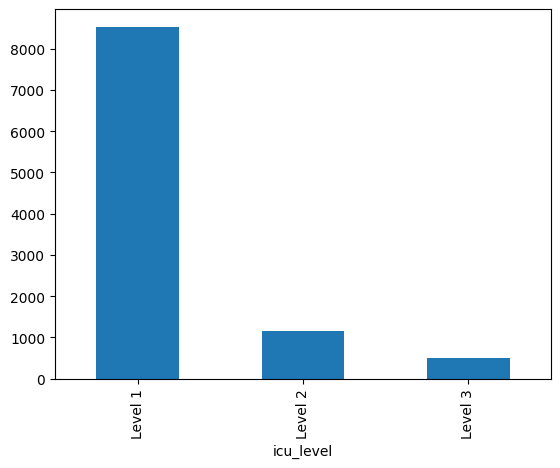

In [43]:
icu_counts = df["icu_level"].groupby(df["icu_level"]).count()
icu_counts.plot(kind="bar")

In [45]:
# Lable Encoding
label_encoder = LabelEncoder()
df["icu_level"] = label_encoder.fit_transform(df["icu_level"])

In [38]:
# Scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

Scaling data...


In [48]:
columns_to_remove = ["subject_id", "hadm_id", "icustay_id", "mr_lods"]
df = df.drop(columns_to_remove, axis=1)

## Clustering and Dimensionality Reduction
For further operation on the dataset we first reduce the dimension of the data. Data has a high number of features (high-dimensional), dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) can be used to reduce the dimensionality. High-dimensional data can suffer from the "curse of dimensionality," leading to increased computational complexity and decreased clustering performance. Reducing dimensionality can help address these issues and improve clustering results. By reducing the dimensionality, you might retain the most important information while discarding noise or irrelevant features, which can lead to more meaningful clustering results.

In [ ]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(scaled_data)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

In [ ]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_result)

Visualizing the reduced dimensions of the dataset

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='b', marker='o', label='t-SNE')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='r', marker='s', label='UMAP')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

Running clustering algorithms on the dimensionality reduced data 

In [ ]:
n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(umap_result)

df['GMM_Cluster_UMAP'] = gmm_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('GMM Clustering using t-SNE')
plt.show()

In [ ]:
# Custom color map for scatter plot
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Scatter plot
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap=cmap, alpha=0.7)

# Highlight cluster number 0 in light blue
highlight_color = cmap(0)
plt.scatter(umap_result[gmm_labels == 0, 0], umap_result[gmm_labels == 0, 1], c=highlight_color, alpha=0.7)

# Set colors for the rest of the clusters to light grey
rest_color = np.array([0.8, 0.8, 0.8])  # RGB values for light grey
for cluster_num in range(1, n_clusters):
    plt.scatter(umap_result[gmm_labels == cluster_num, 0], umap_result[gmm_labels == cluster_num, 1], c=rest_color, alpha=0.7)

plt.colorbar()
plt.title('GMM Clustering using UMAP')
plt.show()

In [ ]:
eps = 0.8
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(umap_result)

df['DBSCAN_Cluster_UMAP'] = dbscan_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('DBSCAN Clustering using t-SNE')
plt.show()

In [ ]:
min_cluster_size = 5

hdb = hdbscan.HDBSCAN(min_samples=min_cluster_size)
hdb_labels = hdb.fit_predict(umap_result)

df['HDBSCAN_Cluster_UMAP'] = hdb_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('HDBSCAN Clustering using t-SNE')
plt.show()

In [ ]:
n_clusters = 5

spectral_clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', random_state=42)
spectral_labels = spectral_clustering.fit_predict(umap_result)

df['Spectral_Cluster_UMAP'] = spectral_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Spectral Clustering using t-SNE')
plt.show()

In [ ]:
n_clusters = 5

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(umap_result)

# df['Birch_Cluster_UMAP'] = birch_labels

# Plotting the Birch clusters in 2D (assuming tsne_result, you can use umap_result as well)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=birch_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Birch Clustering using t-SNE')
plt.show()

In [ ]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_result)

# df['KMeans_Cluster_UMAP'] = kmeans_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('K-means Clustering using t-SNE')
plt.show()

## Cluster Analysis
Further we analyzed each clusters characteristics, how ICU level is scattered around on the clusters, how other features are scatter and affected the clustering and so on

In [ ]:
# num_clusters = len(average_mortality)
# colors = ['grey'] * num_clusters

# colors[2] = 'blue'
# colors[4] = 'red'

# plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[colors[label] for label in df["KMeans_Cluster"]], alpha=0.7)

# plt.colorbar()
# plt.title('KMeans Clustering using t-SNE')
# plt.show()

In [ ]:
# average_mortality = df.groupby('KMeans_Cluster')['mr_lods'].mean()

# print("Average Mortality Rate for Each Cluster:")
# print(average_mortality)

In [ ]:
# median_mortality = df.groupby('Birch_Cluster')['mr_lods'].median()

# print("Median Mortality Rate for Each Cluster:")
# print(median_mortality)

In [ ]:
icu_level_colors = {
    0: 'lightgrey',
    1: 'blue',
    2: 'red'
}

colors_by_icu_level = [icu_level_colors[level] for level in df['icu_level']]

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors_by_icu_level, marker='.', alpha=0.7)

plt.colorbar()
plt.title('ICU Level Colored Clustering using t-SNE')
plt.show()

In [ ]:
# Separate data for cluster 0
cluster_0_data = df[df['GMM_Cluster_UMAP'] == 0]

# Custom color map for scatter plot
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Scatter plot for the rest of the data
rest_data = df[df['GMM_Cluster_UMAP'] != 0]
plt.scatter(umap_result[rest_data.index, 0], umap_result[rest_data.index, 1], c='lightgray', alpha=0.7)

# Scatter plot for cluster 0 with different icu_level colors
cluster_0_icu_0 = cluster_0_data[cluster_0_data['icu_level'] == 0]
cluster_0_icu_1 = cluster_0_data[cluster_0_data['icu_level'] == 1]
cluster_0_icu_2 = cluster_0_data[cluster_0_data['icu_level'] == 2]

plt.scatter(umap_result[cluster_0_icu_0.index, 0], umap_result[cluster_0_icu_0.index, 1], marker='.', c='lightblue', label='Cluster 0 ICU 0', alpha=0.7)
plt.scatter(umap_result[cluster_0_icu_1.index, 0], umap_result[cluster_0_icu_1.index, 1], marker='.', c='lightcoral', label='Cluster 0 ICU 1', alpha=0.7)
plt.scatter(umap_result[cluster_0_icu_2.index, 0], umap_result[cluster_0_icu_2.index, 1], marker='.', c='lightyellow', label='Cluster 0 ICU 2', alpha=0.7)

plt.colorbar()
plt.title('GMM Clustering using UMAP')
plt.legend()
plt.show()

In [ ]:
# Extract cluster 0 data for "icu_level" analysis
cluster_0_icu_levels = cluster_0_data['icu_level']

In [ ]:
# Descriptive statistics
print("Descriptive Statistics for 'icu_level' in Cluster 0:")
print(cluster_0_icu_levels.describe())

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(cluster_0_icu_levels, kde=True, color='lightblue')
plt.xlabel('ICU Level')
plt.ylabel('Frequency')
plt.title('Distribution of ICU Levels in Cluster 0')
plt.show()

In [ ]:
# Groupping by GMM clusters for further individual statistical analysis on each cluster and related
# features
df['GMM_Cluster_UMAP'] = gmm_labels
grouped_clusters = df.groupby('GMM_Cluster_UMAP')

In [ ]:
cluster_means = grouped_clusters.mean()
cluster_means

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap='viridis', annot=True, fmt='.2f')
plt.title('Mean Values of Features for Each Cluster (Heatmap)')
plt.tight_layout()
plt.show()

In [ ]:
cluster_medians = grouped_clusters.median()
cluster_medians

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_medians, cmap='viridis', annot=True, fmt='.2f')
plt.title('Median Values of Features for Each Cluster (Heatmap)')
plt.tight_layout()
plt.show()

In [ ]:
# Get the explained variance ratio, which indicates the importance of each component
explained_variance_ratio = pca.explained_variance_ratio_

In [ ]:
# Create a DataFrame to store the feature importances
pca_importance_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                 index=[f'PC{i+1}' for i in range(20)])

In [ ]:
# Sort the DataFrame by the importance values in descending order
pca_importance_df = pca_importance_df.sort_values(by='Explained Variance Ratio', ascending=False)

In [ ]:
# Print the feature importances
print("PCA Feature Importances:")
print(pca_importance_df)

In [ ]:
# Cumulative sum of explained variance ratio
cumulative_variance = pca_importance_df['Explained Variance Ratio'].cumsum()

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20 + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.xticks(range(1, 20 + 1))
plt.grid(True)
plt.show()

In [ ]:
cluster_labels_list = [
    {
        "name": "KMeans",
        "labels": kmeans_labels        
    },
    {
        "name": "GMM",
        "labels": gmm_labels
    },
    {
        "name": "DBSCAN",
        "labels": dbscan_labels
    },
    {
        "name": "HDBSCAN",
        "labels": hdb_labels
    },
    {
        "name": "BIRCH",
        "labels": birch_labels
    },
    {
        "name": "Spectral Clustering",
        "labels": spectral_labels    
    }
]

for model in cluster_labels_list:    
    silhouette = silhouette_score(umap_result, model["labels"])
    davies_bouldin = davies_bouldin_score(umap_result, model["labels"])
    calinski_harabasz = calinski_harabasz_score(umap_result, model["labels"])
    print(f"Score for {model['name']}")
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print("---------------------------------------------")

In [ ]:
df

In [ ]:
# Saving dataset for use in eda later on
df.to_csv(f'{os.getenv("ROOT_DIR")}\\data\\finalrefinedclustered.csv', index=False)